# Train an NNAlign model to predict both binding core and affinity of MHC ligands
The notebook consists of the following sections:

0. Module imports, define functions, set constants
1. Load Data
2. Build Model
3. Select Hyper-paramerters
4. Compile Model
5. Train Model
6. Evaluation

## Exercise

The exercise is to modify the conventional Feed-Forward Neural Network (FFNN) to use the NNAlign forward algorithm to encode a common binding core length for each peptide, which in our case is 9. To do this, we need to take into account shorter peptides (e.g. 8-mers) and longer peptiders (e.g. 10-11 mers). 

For short peptides, we use an insertion to 'pad' the peptide to the target length of 9. We try all possible positions of this insertion, and use the one giving the highest prediction score from the network. 

For peptides with a length >=9, we try a continuous binding core, and, if the peptide is longer than 9, a binding core where we delete a stretch of amino acids. We try all possible continuous (ungapped) binding cores, and all possible positions of the deletion, and again use the core giving the highest prediction score from the network. 


#### Performance evaluation
Run the notebook and take a look at how the model performs compared to the FFNN on the A0301 dataset 10-11 mers.


# Utility functions

In [44]:
import numpy as np
import pandas as pd
import math
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, matthews_corrcoef

np.random.seed(1) # Set random seed, for reproducibility

In [106]:
def load_blosum(filename):
    """
    Read in BLOSUM values into matrix.
    """
    aa = ['A', 'R', 'N' ,'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'X']
    df = pd.read_csv(filename, sep=r'\s+', comment='#', index_col=0)
    return df.loc[aa, aa]

def load_peptide_target(filename):
    """
    Read amino acid sequence of peptides and
    corresponding log transformed IC50 binding values from text file.
    """
    df = pd.read_csv(filename, sep=r'\s+', usecols=[0,1], names=['peptide','target'])
    return df.sort_values(by='target', ascending=False).reset_index(drop=True)


## Note that encode_peptides is now changed to NOT pad the peptides
## Instead, we save all the non-padded encodings to a list
def encode_peptides(X_in, blosum_file):
    """
    Encode AA seq of peptides using BLOSUM50.
    Returns a list of encoded peptides each of shape (pep_len, n_features)
    """
    blosum = load_blosum(blosum_file)
    
    batch_size = len(X_in)
    n_features = len(blosum)

    encoded_peptides = []

    for peptide_index, row in X_in.iterrows():

        pep_len = row.len
        X_out = np.zeros((pep_len, n_features))

        for aa_index in range(pep_len):
            X_out[aa_index, :] = blosum[ row.peptide[aa_index] ].values

        encoded_peptides.append(X_out)
            
    return encoded_peptides, np.expand_dims(X_in.target.values,1)



In [107]:
# Misc. functions
def invoke(early_stopping, loss, model, implement=False):
    if implement == False:
        return False
    else:
        early_stopping(loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            return True
        
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def plot_losses(train_losses, valid_losses, n_epochs):
    # Plotting the losses 
    fig,ax = plt.subplots(1,1, figsize=(9,5))
    ax.plot(range(n_epochs), train_losses, label='Train loss', c='b')
    ax.plot(range(n_epochs), valid_losses, label='Valid loss', c='m')
    ax.legend()
    fig.show()

In [108]:
def relu_derivative(a):
    # to find
    # return XX
    return (a > 0).astype(float)

def sigmoid_derivative(a):
    # to find
    # return XX
    return a * (1 - a)

def backward(net, x, y, z1, a1, z2, a2, learning_rate=0.01):
    """
    Function to backpropagate the gradients from the output to update the weights.
    Apply the chain rule and slowly work out the chain derivatives from the output back to the input
    Reminder that np.dot(array_1, array_2) and array.T exists to transpose an array for matrix multiplication
    """
    # This assumes that we are computing a MSE as the loss function.
    # Look at your slides to compute the gradient backpropagation for a mean-squared error using the chain rule.

    x = x.reshape(x.shape[0],-1)
    # Output layer error ; We used a sigmoid in this layer
    dE_dO = a2 - y #XX
    dO_do = sigmoid_derivative(a2) #XX
    dE_do = dE_dO * dO_do #XX

    ### (REMEMBER for np.dot(A,B) columns of A MUST equal rows in B) ###
    
    # Backpropagate to hidden layer 
    dE_dW2 = np.dot(a1.T, dE_do) #XX
    dE_db2 = np.sum(dE_do, axis=0, keepdims=True)
    dE_db2 = dE_db2.squeeze() # Squeeze is needed here to make the dimensions fit

    # Hidden layer error ; We used a ReLU in this layer!
    dE_dH = np.dot(dE_do, net.W2.T) #XX
    dE_dh = dE_dH * relu_derivative(a1) #XX

    # Backpropagate to input layer
    dE_dW1 = np.dot(x.T, dE_dh)  #XX
    dE_db1 = np.sum(dE_dh, axis=0, keepdims=True) 
    dE_db1 = dE_db1.squeeze() # Squeeze is needed here to make the dimensions fit

    # Update weights and biases using gradient descent
    net.W1 -= learning_rate * dE_dW1 #XX
    net.b1 -= learning_rate * dE_db1 #XX
    net.W2 -= learning_rate * dE_dW2 #XX
    net.b2 -= learning_rate * dE_db2 #XX
    
def train_network(net, x_train, y_train, learning_rate):
    """
    Trains the network for a single epoch, running the forward and backward pass, and compute and return the loss.
    """
    # Forward pass
    z1, a1, z2, a2, x  = net.forward(x_train)
    # backward pass
    backward(net, x, y_train, z1, a1, z2, a2, learning_rate)
    loss = np.mean((a2 - y_train) ** 2)
    return loss
        
def eval_network(net, x_valid, y_valid):
    """
    Evaluates the network ; Note that we do not update weights (no backward pass)
    """
    z1, a1, z2, a2, _ = net.forward(x_valid)
    loss = np.mean((a2-y_valid)**2)
    return loss

In [88]:
# Weights initialization function.
# xavier initialization is technically more stable and preferred 
# (See slides)
def xavier_initialization_normal(input_dim, output_dim):
    shape = (input_dim, output_dim)
    stddev = np.sqrt(2 / (input_dim + output_dim))
    return np.random.normal(0, stddev, size=shape) * 0.1

def random_initialization_normal(input_dim, output_dim):
    return np.random.randn(input_dim, output_dim) * 0.1

In [89]:
# Model saving and loading functions
def save_nnalign_model(filepath, model):
    if not filepath.endswith('.pkl'):
        filepath = filepath+'.pkl'
    with open(filepath, 'wb') as f:
        dict_to_save = {'input_size': model.W1.shape[0], 
                        'hidden_size':model.W1.shape[1], 
                        'output_size':model.W2.shape[1], 
                        'motif_len': model.motif_len, 
                        'encoding_dim': model.encoding_dim,
                        'W1': model.W1, 'b1':model.b1, 'W2':model.W2, 'b2':model.b2}
        pickle.dump(dict_to_save, f)
        print(f'Saved NNAlign model at {filepath}')

def load_nnalign_model(filepath, model=None):

    with open(filepath, 'rb') as f:
        loaded_dict = pickle.load(f)
    if model is None:
            model = NNAlign(loaded_dict['input_size'], loaded_dict['hidden_size'], loaded_dict['output_size'], loaded_dict['motif_len'],loaded_dict['encoding_dim'])
    assert (model.W1.shape[0]==loaded_dict['input_size'] and model.W1.shape[1]==loaded_dict['hidden_size'] and model.W2.shape[1]==loaded_dict['output_size']), \
        f"Model and loaded weights size mismatch!. Provided model has weight of dimensions {model.W1.shape, model.W2.shape} ; Loaded weights have shape {loaded_dict['W1'].shape, loaded_dict['W2'].shape}"

    model.W1 = loaded_dict['W1']
    model.b1 = loaded_dict['b1']
    model.W2 = loaded_dict['W2']
    model.b2 = loaded_dict['b2']
    print(f"Model loaded successfully from {filepath}\nwith weights [ W1, W2 ] dimensions : {model.W1.shape, model.W2.shape}")
    return model

# Data loading and encoding

In [90]:
# Replace your data paths with the actual paths and desired allele
ALLELE = 'A0301'
DATAPATH = '/Users/jonnil/phd/phd/algo/NNDeep'
blosum_file = f'{DATAPATH}/BLOSUM50'
train_data = f'{DATAPATH}/{ALLELE}/train_BA'
valid_data = f'{DATAPATH}/{ALLELE}/valid_BA'
test_data = f'{DATAPATH}/{ALLELE}/test_BA'

# Loading the peptides.
train_raw = load_peptide_target(train_data)
valid_raw = load_peptide_target(valid_data)
test_raw = load_peptide_target(test_data)
# 

print('Maximum peptide length of each data set:')
print('Train:\t',  train_raw['peptide'].apply(len).max())
print('Valid:\t', valid_raw['peptide'].apply(len).max())
print('Test:\t', test_raw['peptide'].apply(len).max())

train_raw['len'] = train_raw['peptide'].apply(len)
valid_raw['len'] = valid_raw['peptide'].apply(len)
test_raw['len'] = test_raw['peptide'].apply(len)
print('Peptide length counts in the train data')

print('N_datapoints:')
print('Train data:\t', train_raw.shape[0])
print('Valid data:\t', valid_raw.shape[0])
print('Test data:\t', test_raw.shape[0])

x_train_, y_train_ = encode_peptides(train_raw, blosum_file)
x_valid_, y_valid_ = encode_peptides(valid_raw, blosum_file)
x_test_, y_test_ = encode_peptides(test_raw, blosum_file)

Maximum peptide length of each data set:
Train:	 11
Valid:	 11
Test:	 11
Peptide length counts in the train data
N_datapoints:
Train data:	 3951
Valid data:	 1329
Test data:	 1321


In [91]:
test_raw.len.value_counts()

len
9     981
10    309
11     22
8       9
Name: count, dtype: int64

# Model creation and training

## Model definition

Now it's your turn. 

For the forward pass, you will need to fill in the missing parts in the foreward function (indicated by XXXX), which relate to the encoding of the peptide binding core.

In [99]:
class NNAlignFFNN:
    def __init__(self, input_size, hidden_size, output_size, motif_len, encoding_dim, initialization_function=xavier_initialization_normal):
        # Initialize weights and biases with small random values
        # initialization_function(input_dim, output_dim) -> np.array of shape (input_dim, output_dim)
        self.W1 = initialization_function(input_size, hidden_size) # XX
        self.b1 = np.zeros(hidden_size) # XX
        self.W2 = initialization_function(hidden_size, output_size) # XX
        self.b2 = np.zeros(output_size) # XX
        self.motif_len = motif_len
        self.encoding_dim = encoding_dim
        print(self.W1.shape, self.b1.shape, self.W2.shape, self.b2.shape, motif_len, encoding_dim)
    
    def relu(self, x):
        return np.maximum(0, x)

    # This version of sigmoid here is NOT numerically stable.
    # We need to split the cases where the input is positive or negative
    # because np.exp(-x) for something negative will quickly overflow if x is a large negative number
    # def sigmoid(self, x):
    #     return 1 / (1 + np.exp(-x))

    def sigmoid(self, x): 
        # This is equivalent to : 
        # if x>=0, then compute (1/(1+np.exp(-x)))
        # else: compute (np.exp(x)/(1+np.exp(x))))
        return np.where(x >= 0, 1 / (1 + np.exp(-x)), 
                        np.exp(x) / (1 + np.exp(x)))

    def forward_inp(self, x):   
        """
        zi denotes the output of a hidden layer i
        ai denotes the output of an activation function at layer i
        (activations are relu, sigmoid, tanh, etc.)
        """

        # First layer
        z1 = np.dot(x, self.W1) + self.b1  # np.dot does for hidden layer node j, z_j = sum(x_i*w_ij for i in input_size)
        a1 = self.relu(z1)

        # Output layer
        z2 = np.dot(a1, self.W2) + self.b2 # np.dot does for output node o, z_o = sum(a1_j*w_jo for j in hidden_size)
        a2 = self.sigmoid(z2)

        # Return all the intermediate outputs as well because we need them for backpropagation (see slides)
        return z1, a1, z2, a2


    def forward(self, x):
        """
        x is a list of non-padded input arrays 
        """

        x_fwd_all = []
        bounds = []  # list of tuples: holds the candidate forward index range per peptide
        x_templates = [] # list of arrays: holds the candidate binding core encodings per peptide

        # First collect all input encodings to try 
        for i in range(len(x)):
            pep_len = x[i].shape[0]

            # Peptide is shorter than motif length. Insertion
            if pep_len < self.motif_len:
                len_ins = self.motif_len - pep_len
                num_ins = pep_len + 1 # Number of insertion positions to try

                x_fwd = np.zeros((num_ins, self.motif_len, self.encoding_dim))

                # Try all insertion positions
                for idx, j in enumerate(range(num_ins)):

                    # Encode the binding core
                    x_fwd[idx][:j] = XXXX                                # Up to insertion <-- TO FILL IN
                    x_fwd[idx][j:j + len_ins] = 0.0                      # Insertion wildcards
                    x_fwd[idx][j + len_ins:] = XXXX                      # After insertion <-- TO FILL IN
                
                bounds.append((len(x_fwd_all), len(x_fwd_all) + num_ins))
                x_templates.append(x_fwd)
                x_fwd_all.extend(x_fwd)
        
            else: 

                del_len = pep_len - self.motif_len                      # potential deletion length, if any
                num_del = pep_len - del_len - 1 if del_len > 0 else 0   # Number of deletion positions to try, if any
                num_offsets = pep_len - self.motif_len + 1              # Number of ungapped core offsets to try

                x_fwd = np.zeros((num_offsets + num_del, self.motif_len, self.encoding_dim))

                # Try all continuous binding cores within the peptide, without deletions
                for idx, j in enumerate(range(num_offsets)):

                    # Encode the binding core
                    x_fwd[idx] = x[i][j:j+XXXX]                         # <-- TO FILL IN

                if del_len > 0:
        
                    # Try all deletion positions starting after the first residue and ending before the last residue
                    for idx, j in enumerate(range(1, pep_len - del_len)):

                        # Encode the binding core
                        x_fwd[num_offsets + idx][:j] = x[i][:j]         # Up to deletion
                        x_fwd[num_offsets + idx][j:] = XXXX             # After deletion <-- TO FILL IN
                    
                bounds.append((len(x_fwd_all), len(x_fwd_all) + num_offsets + num_del))
                x_templates.append(x_fwd)
                x_fwd_all.extend(x_fwd)

        # Stack and forward once - more efficient than individually forwarding potential encodings for each peptide
        x_fwd_all = np.stack(x_fwd_all)  # shape (total_candidates, motif_len, encoding_dim)
        z1_all, a1_all, z2_all, a2_all = self.forward_inp(x_fwd_all.reshape(x_fwd_all.shape[0], -1)) # reshape to flatten the last two dimensions

        # Collect best candidates per input
        x_all, z1, a1, z2, a2 = [], [], [], [], []

        for i, (start, end) in enumerate(bounds):
            best_idx = np.argmax(a2_all[start:end])
            x_all.append(x_templates[i][best_idx]) # the optimal peptide encodings are used during backpropagation
            z1.append(z1_all[start + best_idx])
            a1.append(a1_all[start + best_idx])
            z2.append(z2_all[start + best_idx])
            a2.append(a2_all[start + best_idx])

        return np.array(z1), np.array(a1), np.array(z2), np.array(a2), np.array(x_all)




## Now create a model and run it.

Play around with the hyperparameters (number of epochs, learning rate, hidden size) and see what the changes do!

In [100]:
# Reshaping the matrices so they're flat because feed-forward networks are "one-dimensional"
# Define sizes
input_size = 9 * 21 # also known as "n_features"
# Model and training hyperparameters
learning_rate = 0.0001
hidden_units = 100
n_epochs = 500
output_size = 1
# Creating a model instance 
# You can use either `xavier_initialization_normal` or `random_initialization_normal`
# for the initialization_function argument of the class
network = NNAlignFFNN(input_size, hidden_units, output_size, 9, 21)#, 
                     #initialization_function=xavier_initialization_normal)


(189, 100) (100,) (100, 1) (1,) 9 21


In [101]:
# Training loops
train_losses = []
valid_losses = []

# Run n_epochs of training
for epoch in range(n_epochs):
    train_loss = train_network(network, x_train_, y_train_, learning_rate)
    valid_loss = eval_network(network, x_valid_, y_valid_)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    # For the first, every 5% of the epochs and last epoch, we print the loss 
    # to check that the model is properly training. (loss going down)
    if (n_epochs >= 10 and epoch % math.ceil(0.05 * n_epochs) == 0) or epoch == 0 or epoch == n_epochs:
        print(f"Epoch {epoch}: \n\tTrain Loss:{train_loss:.4f}\tValid Loss:{valid_loss:.4f}")

Epoch 0: 
	Train Loss:0.1068	Valid Loss:0.1014
Epoch 25: 
	Train Loss:0.0430	Valid Loss:0.0410
Epoch 50: 
	Train Loss:0.0364	Valid Loss:0.0354
Epoch 75: 
	Train Loss:0.0318	Valid Loss:0.0317
Epoch 100: 
	Train Loss:0.0286	Valid Loss:0.0291
Epoch 125: 
	Train Loss:0.0266	Valid Loss:0.0275
Epoch 150: 
	Train Loss:0.0290	Valid Loss:0.0291
Epoch 175: 
	Train Loss:0.0260	Valid Loss:0.0278
Epoch 200: 
	Train Loss:0.0262	Valid Loss:0.0267
Epoch 225: 
	Train Loss:0.0250	Valid Loss:0.0274
Epoch 250: 
	Train Loss:0.0249	Valid Loss:0.0259
Epoch 275: 
	Train Loss:0.0243	Valid Loss:0.0271
Epoch 300: 
	Train Loss:0.0238	Valid Loss:0.0254
Epoch 325: 
	Train Loss:0.0236	Valid Loss:0.0267
Epoch 350: 
	Train Loss:0.0232	Valid Loss:0.0252
Epoch 375: 
	Train Loss:0.0226	Valid Loss:0.0262
Epoch 400: 
	Train Loss:0.0225	Valid Loss:0.0250
Epoch 425: 
	Train Loss:0.0221	Valid Loss:0.0264
Epoch 450: 
	Train Loss:0.0217	Valid Loss:0.0248
Epoch 475: 
	Train Loss:0.0218	Valid Loss:0.0265


In [102]:
# Put your own savename to be used for the model and predictions
savepath='nnalign_model' 
# saving the model to a file
# Use the .pkl extension to save python pickled files
save_nnalign_model(f'{savepath}.pkl', model=network)

Saved NNAlign model at nnalign_model.pkl


# Evaluation on test data

In this part, you will reload a trained model and use it for evaluation.

The binding affinity data has the actual normalized binding affinity value for targets (0,1). In order to compute an AUC, we need to binarize these values into class labels of y=0 or y=1. We use the BINDER_THRESHOLD of 0.426 to do so.

Have a look at how the predictions scores are obtained. The predictions scores are the output of the network after a sigmoid function.

Model loaded successfully from nnalign_model.pkl
with weights [ W1, W2 ] dimensions : ((189, 100), (100, 1))


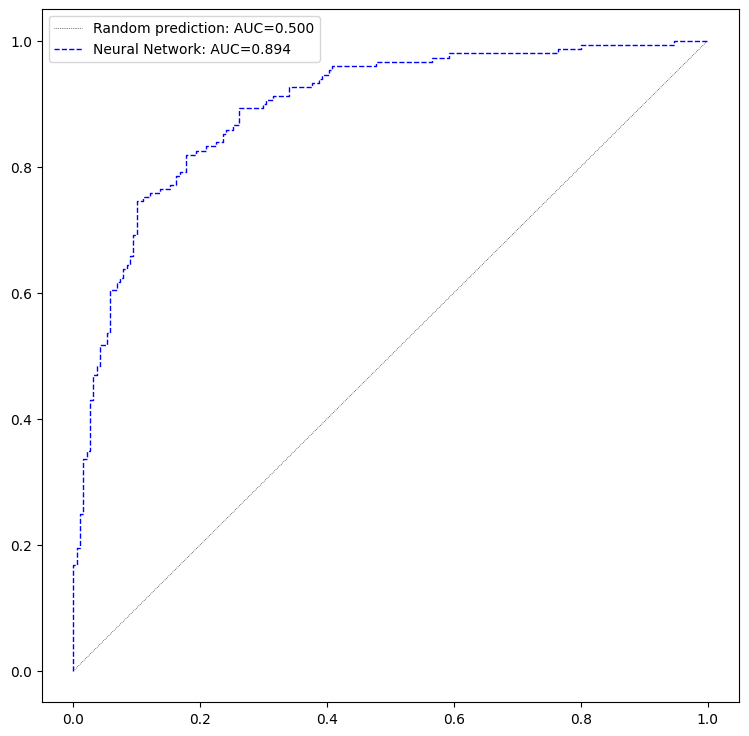

In [112]:
from sklearn.metrics import roc_auc_score, roc_curve
# Reload the model and evaluate it
reloaded_network = load_nnalign_model(f'{savepath}.pkl', model=network)

BINDER_THRESHOLD=0.426
# Thresholding the targets
y_test_thresholded = (y_test_>=BINDER_THRESHOLD).astype(int)

_, _, _, test_predictions_scores, _ = reloaded_network.forward(x_test_)


# Define subset of test data
idx = [i for i in range(len(test_raw)) if len(test_raw.iloc[i].peptide) != 9]

test_auc = roc_auc_score(y_test_thresholded.squeeze()[idx], test_predictions_scores.squeeze()[idx])
test_fpr, test_tpr, _ = roc_curve(y_test_thresholded.squeeze()[idx], test_predictions_scores.squeeze()[idx])

f,a = plt.subplots(1,1 , figsize=(9,9))

a.plot([0,1],[0,1], ls=':', lw=0.5, label='Random prediction: AUC=0.500', c='k')
a.plot(test_fpr, test_tpr, ls='--', lw=1, label=f'Neural Network: AUC={test_auc:.3f}', c='b')
a.legend()
plt.show()

Hopefully you will see that using the NNAlign model results in better performance for the 8 and 10-11 mers in A0301.